/tmp/ipykernel_420/1021972801.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
/tmp/ipykernel_420/1021972801.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


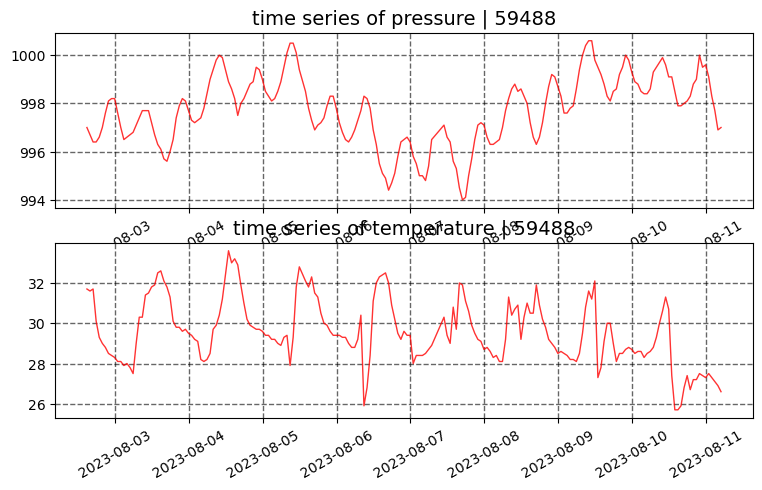

In [23]:
import platform
import os, glob
import pytz
from datetime import datetime
from scipy.interpolate import griddata
import numpy as np, pandas as pd, xarray as xr

# 5. image processing
import imageio
import cartopy.io.shapereader as shapereader
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def indexingData2D(varname='pressure', provinces=['广东'], time=None, mode='cubic', dirname=None, unavai=[]):
    result_data_dirname = os.path.join(dirname, 'data', 'result')
    df_addr = pd.read_excel(os.path.join(dirname, 'stations.xlsx'), sheet_name='开放站点')
    df_addr['区站号'] = df_addr['区站号'].astype(np.int64)
    df_addr.set_index('区站号', inplace=True)

    abspaths = glob.glob(os.path.join(result_data_dirname, '*.csv'))
    fnames = [abspath.split(os.sep)[-1] for abspath in abspaths]
    record_dates = [datetime.strptime(fname.split('.')[0], '%y-%m-%d_%H%M%S') for fname in fnames]
    filename = fnames[record_dates.index(max(record_dates))]
    df = pd.read_csv(os.path.join(result_data_dirname, filename))
    for label in ['number', 'year', 'month', 'day', 'hour']:
        df.loc[:, label] = df.loc[:, label].astype(np.int64)
    df.set_index('number', inplace=True)
    
    if unavai:
        for num in unavai:
            if num in df_addr.index:
                df_addr.drop(index=num, inplace=True)
            if num in df.index:
                df.drop(index=num, inplace=True)
    if provinces == 'all':
        provinces = df_addr['省份']
    idx1 = df_addr.index[df_addr['省份'].isin(provinces)]
    lon = df_addr.loc[idx1, '经度']
    lat = df_addr.loc[idx1, '纬度']
    df = df.loc[idx1]

    varidxes = {'pressure': '地面气压', 
                'temperature': '瞬时温度', 
                'humidity': '相对湿度', 
                'wind speed': '瞬时风速', 
                'gust': '1小时极大风速', 
                'precipitation': '1小时降水', 
                'visibility': '10分钟平均能见度'}

    varunits = {'pressure': 'hPa',
                'temperature': '°C', 
                'humidity': '%',
                'wind speed': 'm/s',
                'gust': 'm/s', 
                'precipitation': 'mm/day', 
                'visibility': 'm'}
    china_timezone = pytz.timezone('Asia/Shanghai')
    date = china_timezone.localize(time)
    idx2 = (df['year'] == date.year)&(df['month'] == date.month)&(df['day'] == date.day)&(df['hour'] == date.hour)
    var = df.loc[idx2, varidxes[varname]]

    var[var == '-'] = np.nan
    var = var.apply(lambda x: x.strip('()') if isinstance(x, str) else x)
    var = var.astype(np.float64)

    grid_lon, grid_lat = np.meshgrid(sorted(lon), sorted(lat))
    ########################
    for i in lon.index:
        if not (i in var.index):
            print(i)
    grid_var = griddata((lon, lat), var, (grid_lon, grid_lat), method=mode)
    # grid_var = np.where(grid_var < 900, np.nan, grid_var) # if varname == 'pressure' else grid_var

    da = xr.DataArray(grid_var.reshape(1, grid_var.shape[0], grid_var.shape[1]), coords=[pd.date_range(date.strftime('%Y-%m-%d %H:%M:%S'), periods=1), sorted(lat), sorted(lon)], dims=['time', 'lat', 'lon'])
    ds = xr.Dataset({varname: da})
    ds[varname].attrs['long_name'] = varname
    ds[varname].attrs['units'] = varunits[varname]
    
    print(min(lon), max(lon), min(lat), max(lat))
    print(grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max())
    
    return ds

def plotData2D(ds=None, varname='pressure', time=None, cmap='bwr'):
    china_timezone = pytz.timezone('Asia/Shanghai')
    date = china_timezone.localize(time)
    
    proj = ccrs.LambertConformal(central_longitude=110.0, central_latitude=35.0, standard_parallels=(30.0, 60.0))
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': proj})

    ax.set_extent([min(ds.lon), max(ds.lon), min(ds.lat), max(ds.lat)], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8), ax.add_feature(cfeature.STATES, linewidth=0.8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, linestyle='dashed', color='k', alpha=0.8, x_inline=False, y_inline=False)
    gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()
    gl.right_labels, gl.top_labels = False, False

    # im = ax.scatter(lon, lat, c=pres, s=25, cmap='bwr', transform=ccrs.PlateCarree(), zorder=1)
    im = ax.contourf(ds.lon, ds.lat, ds[varname].squeeze(), cmap=cmap, zorder=0, transform=ccrs.PlateCarree())
    ax.set_title(f"contourf graph of {ds[varname].attrs['long_name']} | {date.strftime('%Y-%m-%d %H:%M:%S')}", size=14)
    cbar = fig.colorbar(im, label=f"units: {ds[varname].attrs['units']}", orientation='horizontal')

    plt.show()

def indexingData1D(site=None, dirname=None):
    result_data_dirname = os.path.join(dirname, 'data', 'result')

    abspaths = glob.glob(os.path.join(result_data_dirname, '*.csv'))
    fnames = [abspath.split(os.sep)[-1] for abspath in abspaths]
    record_dates = [datetime.strptime(fname.split('.')[0], '%y-%m-%d_%H%M%S') for fname in fnames]
    filename = fnames[record_dates.index(max(record_dates))]
    df = pd.read_csv(os.path.join(result_data_dirname, filename))
    for label in ['number', 'year', 'month', 'day', 'hour']:
        df.loc[:, label] = df.loc[:, label].astype(np.int64)
    df = df.loc[df['number'] == site, :]
    for idx in df.index:
        df.loc[idx, 'date'] = datetime(df.loc[idx, 'year'], df.loc[idx, 'month'], df.loc[idx, 'day'], df.loc[idx, 'hour'], tzinfo=pytz.timezone('Asia/Shanghai'))
    df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
    df.set_index('number', inplace=True)
    return df
    
def plotData1D(df=None, site=None, varnames=['pressure']):
    
    varidxes = {'pressure': '地面气压', 'temperature': '瞬时温度'}
    pcolors = {'pressure': 'blue', 'temperature': 'r'}
    fig, axs = plt.subplots(nrows=len(varnames), figsize=(9, 5))
    for ax, varname in zip(axs, varnames):
        var = df[varidxes[varname]].copy()
        var[var == '-'] = np.nan
        var = var.apply(lambda x: x.strip('()') if isinstance(x, str) else x)
        var = var.astype(np.float64)
        ax.grid('on', linewidth=1, linestyle='dashed', color='k', alpha=0.6)
        p = ax.plot(df.date, var, linewidth=1, linestyle='solid', color='r', alpha=0.8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        ax.set_title(f"time series of {varname} | {site}", size=14)
    
    plt.show()

###################################
if platform.system() == 'Windows':
    dirname = os.path.join('D:\\Documents', 'A-threads', 'less important ones', 'thread2308-4_try_to_purchase_chinese_station_api')
elif platform.system() == 'Linux':
    dirname = os.getcwd()

varname = 'humidity'
# provinces = ['广东', '广西', '福建', '湖南', '海南', '江西']
provinces = 'all'
time = datetime(2023, 8, 8, 12)
unavai = [53392, 54501, 54597, 57575, 57577, 57623, 57744, 57805, 58004, 58321, 58458, 58903]
# ds = indexingData2D(varname=varname, provinces=provinces, time=time, mode='linear', dirname=dirname, unavai=unavai)
# plotData2D(ds=ds, varname=varname, time=time, cmap='viridis')

site = 59488
varnames = ['pressure', 'temperature']
df = indexingData1D(site=site, dirname=dirname)
plotData1D(df=df, site=site, varnames=varnames)